## Analísis a precios de propiedades

Proyecto realizado por: 

Fuentes de datos:

1. **ids_clean.csv** (Índice de Desarrollo Social por Colonias de la Ciudad de México) obtenido a partir de este [enlace](https://evalua.cdmx.gob.mx/principales-atribuciones/medicion-del-indice-de-desarrollo-social-de-las-unidades-territoriales/medicion-del-indice-de-desarrollo-social-de-las-unidades-territoriales/bases-de-datos). Consultado el 12 de diciembre de 2023.

2. **inmuebles24_2.csv** (Scraping a diferentes inmuebles dentro de la ciudad de México) obtenido a partir de la pagina www.inmuebles24.com mediante el uso de webscraping. Realizado el 8 de enero de 2024 con la finalidad de obtener los datos más recientes.

Pasos a seguir:

- **Transformacion de datos**: Unir ambas bases de datos (Indice de desarrollo social y scraping a pagina de renta de inmuebles) mediante el nombre de colonia.
- **EDA**: Realizar un Analísis exploratorio a los datos con la finalidad de encontrar hallazgos.
- Buscar el mejor modelo para adaptar una prediccion de precio de los propiedades dado la zona y el número de metros cuadrados.

Importar librerias que vamos a utilizar

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [22]:
df_inmuebles = pd.read_csv('./datasets/inmuebles24_clean.csv'  , encoding='utf8')
df_ids = pd.read_csv('./datasets/ids_clean.csv'  , encoding='utf8')

In [23]:
df_inmuebles.head(3)

,precio,ubicacion,tamanio,metros_cuadrados,num_baños,num_estacionamientos,num_recamaras,antiguedad,calle,colonia,alcaldia
0,35000,"Calle Lago Zurich 219, Ampliación Granada, M...",7111,1,1,1,1,1.0,Calle Lago Zurich 219,Ampliación Granada,Miguel Hidalgo
1,90000,"Bosques de La Reforma, Bosque de las Lomas, ...",39943,399,5,3,3,4.0,Bosques de La Reforma,Bosque de las Lomas,Miguel Hidalgo
2,30014,"El Yaqui , El Yaqui, Cuajimalpa de Morelos",10622,106,2,2,2,2.0,El Yaqui,El Yaqui,Cuajimalpa de Morelos


In [24]:
df_ids.head(3)

,MUNICIPIO,COLONIA,indice,indice_texto
0,AZCAPOTZALCO,AGUILERA,0.841408,Medio
1,AZCAPOTZALCO,ALDANA,0.845086,Medio
2,AZCAPOTZALCO,PETROLERA (AMPL),0.907984,Alto


In [25]:
from fuzzywuzzy import fuzz

In [26]:
import pandas as pd
from fuzzywuzzy import fuzz

# Limpiar y estandarizar los nombres de colonias en ambos conjuntos de datos
df_ids['colonia_clean'] = df_ids['COLONIA'].apply(lambda x: str(x).lower().strip())

df_inmuebles['colonia_clean'] = df_inmuebles['colonia'].apply(lambda x: str(x).lower().strip())

#reemplazar los acentos en los nombres de colonias en ambos conjuntos de datos
df_ids['colonia_clean'] = df_ids['colonia_clean'].str.replace('á','a')
df_ids['colonia_clean'] = df_ids['colonia_clean'].str.replace('é','e')
df_ids['colonia_clean'] = df_ids['colonia_clean'].str.replace('í','i')
df_ids['colonia_clean'] = df_ids['colonia_clean'].str.replace('ó','o')
df_ids['colonia_clean'] = df_ids['colonia_clean'].str.replace('ú','u')

df_inmuebles['colonia_clean'] = df_inmuebles['colonia_clean'].str.replace('á','a')
df_inmuebles['colonia_clean'] = df_inmuebles['colonia_clean'].str.replace('é','e')
df_inmuebles['colonia_clean'] = df_inmuebles['colonia_clean'].str.replace('í','i')
df_inmuebles['colonia_clean'] = df_inmuebles['colonia_clean'].str.replace('ó','o')
df_inmuebles['colonia_clean'] = df_inmuebles['colonia_clean'].str.replace('ú','u')



__FuzzyWuzzy__

Tiene como objetivo la busqueda de coincidencia difusa , esta es útil cuando necesitas comparar cadenas de texto que pueden tener pequeñas variaciones o errores tipográficos como en este caso de uso con la escritura de colonias en ambos datasets.

__fuzzywuzzy,__ funciona mediante un  algoritmo de comparación de cadenas llamado Ratio de Levenshtein para medir la similitud entre dos cadenas. Devuelve un valor de 0 a 100, donde 100 indica una coincidencia perfecta. __extractOne__ se utiliza aquí para obtener la mejor coincidencia única.

In [27]:
from fuzzywuzzy import process
 
def obtener_mejor_coincidencia(row, opciones):
    mejor_coincidencia = process.extractOne(row['colonia_clean'], opciones)
    return mejor_coincidencia[0]

 
df_inmuebles['mejor_coincidencia'] = df_inmuebles.apply(obtener_mejor_coincidencia, opciones=df_ids['colonia_clean'], axis=1)

# Fusionar los conjuntos de datos en base a la mejor coincidencia
df_final = pd.merge(df_inmuebles, df_ids, left_on='mejor_coincidencia', right_on='colonia_clean', how='left')


In [28]:
df_final.head(5)

,precio,ubicacion,tamanio,metros_cuadrados,num_baños,num_estacionamientos,num_recamaras,antiguedad,calle,colonia,alcaldia,colonia_clean_x,mejor_coincidencia,MUNICIPIO,COLONIA,indice,indice_texto,colonia_clean_y
0,35000,"Calle Lago Zurich 219, Ampliación Granada, M...",7111,1,1,1,1,1.0,Calle Lago Zurich 219,Ampliación Granada,Miguel Hidalgo,ampliacion granada,granada,MIGUEL HIDALGO,GRANADA,0.928227,Alto,granada
1,90000,"Bosques de La Reforma, Bosque de las Lomas, ...",39943,399,5,3,3,4.0,Bosques de La Reforma,Bosque de las Lomas,Miguel Hidalgo,bosque de las lomas,bosques de las lomas,CUAJIMALPA DE MORELOS,BOSQUES DE LAS LOMAS,0.912393,Alto,bosques de las lomas
2,90000,"Bosques de La Reforma, Bosque de las Lomas, ...",39943,399,5,3,3,4.0,Bosques de La Reforma,Bosque de las Lomas,Miguel Hidalgo,bosque de las lomas,bosques de las lomas,MIGUEL HIDALGO,BOSQUES DE LAS LOMAS,0.978901,Muy Alto,bosques de las lomas
3,30014,"El Yaqui , El Yaqui, Cuajimalpa de Morelos",10622,106,2,2,2,2.0,El Yaqui,El Yaqui,Cuajimalpa de Morelos,el yaqui,el yaqui,CUAJIMALPA DE MORELOS,EL YAQUI,0.944309,Muy Alto,el yaqui
4,21500,"José María Rico, Del Valle Sur, Benito Juárez",9022,90,2,2,2,2.0,José María Rico,Del Valle Sur,Benito Juárez,del valle sur,valle del sur,IZTAPALAPA,VALLE DEL SUR,0.836689,Medio,valle del sur


Eliminar columnas que no se usaran como colonia, colonia_clean_x , MUNICIPIO, COLONIA, colonia_clean_y y ubicacion

__Colonia_clean_x__ y __colonia_clean_y__ corresponden a la busqueda de fuzzywuzzy de ambos datasets, como ya creamos la columna mejor_coincidencia, estas ya dejan de ser reelevantes.

In [29]:
df = df_final.drop(['colonia', 'colonia_clean_x', 'alcaldia', 'COLONIA', 'colonia_clean_y'], axis=1)


In [30]:
df = df.drop(['ubicacion'], axis=1)

----------------------------

### Limpieza de información

Generaremos una descripcion de los datos

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557 entries, 0 to 556
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   precio                557 non-null    int64  
 1   tamanio               557 non-null    int64  
 2   metros_cuadrados      557 non-null    int64  
 3   num_baños             557 non-null    int64  
 4   num_estacionamientos  557 non-null    int64  
 5   num_recamaras         557 non-null    int64  
 6   antiguedad            542 non-null    float64
 7   calle                 557 non-null    object 
 8   mejor_coincidencia    557 non-null    object 
 9   MUNICIPIO             557 non-null    object 
 10  indice                557 non-null    float64
 11  indice_texto          557 non-null    object 
dtypes: float64(2), int64(6), object(4)
memory usage: 52.3+ KB


In [32]:
df.describe()

,precio,tamanio,metros_cuadrados,num_baños,num_estacionamientos,num_recamaras,antiguedad,indice
count,5.570000e+02,557.000000,557.000000,557.000000,557.00000,557.00000,542.000000,557.000000
mean,6.583084e+05,14156.000000,86.761221,1.929982,1.86535,1.86535,3.592251,0.906405
std,2.867812e+06,19218.225789,191.669601,0.782301,0.77842,0.77842,5.951885,0.049346
min,5.000000e+03,3711.000000,1.000000,1.000000,1.00000,1.00000,1.000000,0.705801
25%,2.150000e+04,7522.000000,3.000000,1.000000,1.00000,1.00000,1.000000,0.877190
50%,3.000000e+04,10332.000000,70.000000,2.000000,2.00000,2.00000,2.000000,0.916413
75%,4.900000e+04,15021.000000,115.000000,2.000000,2.00000,2.00000,3.000000,0.940618
max,3.200000e+07,300021.000000,3000.000000,5.000000,6.00000,6.00000,60.000000,0.978901


Grafico de dispercion de nuestros datos

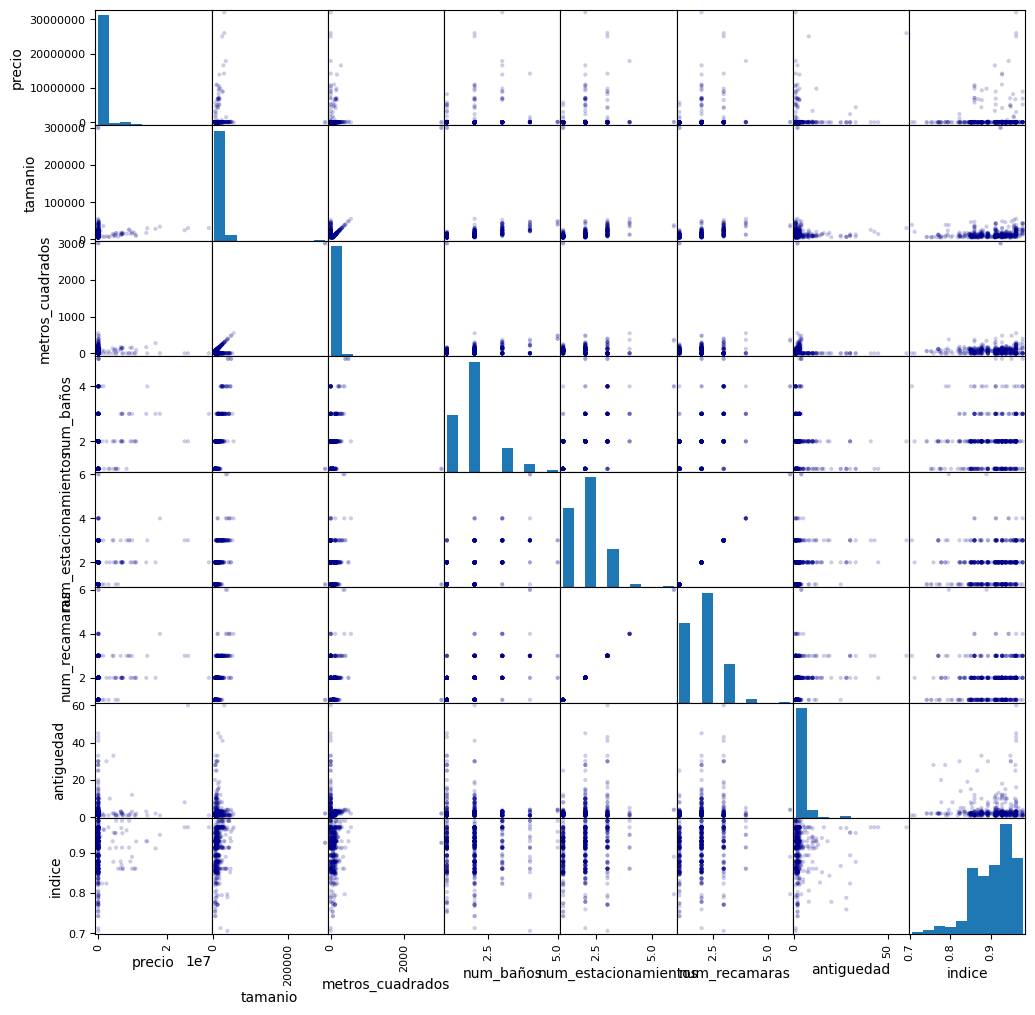

In [33]:
from pandas.plotting import scatter_matrix

scatter_matrix(df, alpha=0.2, figsize=(12, 12), diagonal='hist', color='DarkBlue')
plt.show()


Se observa un patrón marcado entre el número de recámaras y el número de estacionamientos. Esto sugiere que, en general, las propiedades con un mayor número de recámaras tienden a tener más estacionamientos. Este patrón podría ser útil para entender las preferencias o características comunes en las propiedades.
Antigüedad vs. Tamaño:

Se destaca la dificultad para encontrar propiedades con tamaño grande y mucha antigüedad. Esta observación podría indicar que las propiedades más antiguas tienden a ser más pequeñas, o que las propiedades más grandes son relativamente más recientes en comparación. Este patrón puede estar relacionado con las preferencias de construcción a lo largo del tiempo.
Metros Cuadrados vs. Precio:

La observación de que existen muchas propiedades con poco tamaño pero con precios variables destaca la variabilidad en los precios independientemente del tamaño. Esto podría deberse a otros factores influyentes, como la ubicación, la calidad de la construcción, o las comodidades disponibles en la propiedad.
Índice vs. Precio:

Es difícil encontrar un patrón entre el índice y el precio de la propiedad. Esta observación sugiere que el índice puede no tener una correlación clara con el precio. Puede ser útil explorar más a fondo o considerar otras variables que podrían influir en el precio de la propiedad.

### Boxplots para observar los valores atipicos

Los boxplots son una herramienta valiosa para resumir y visualizar la distribución estadística de los datos, proporcionando una comprensión rápida y efectiva de la forma y la dispersión de la información.

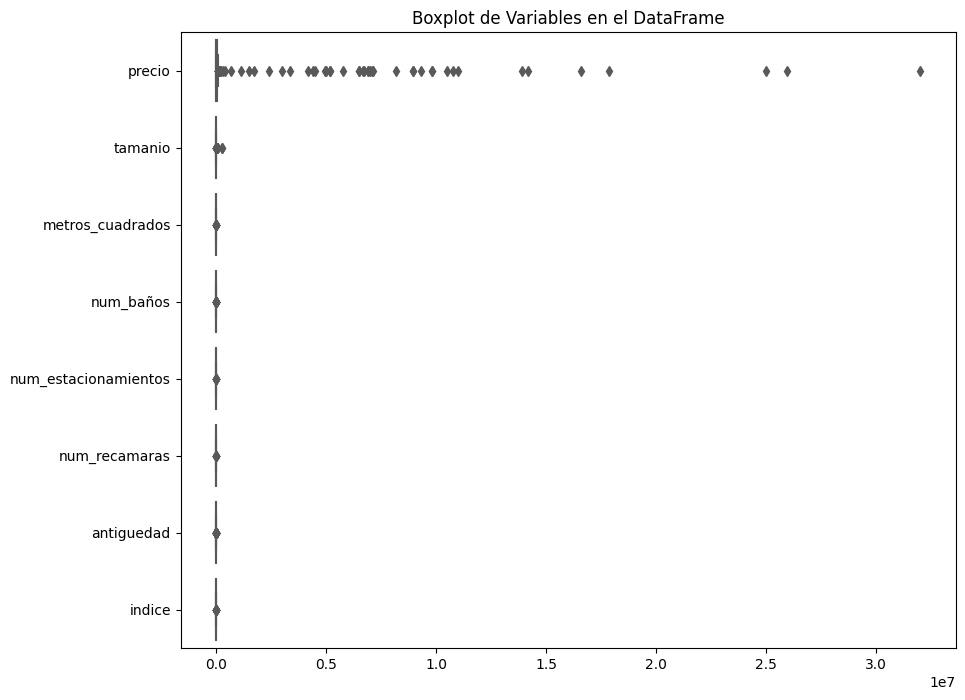

In [34]:
plt.figure(figsize=(10, 8))
sns.boxplot(data=df, orient='h', palette='Set2')
 
plt.title('Boxplot de Variables en el DataFrame')
plt.show()

Observamos que en precio y tamanio existen gran cantidad de outliers, vamos a analizar estos más a fondo y trataremos de reducir esos valores atípicos.

<Axes: xlabel='precio'>

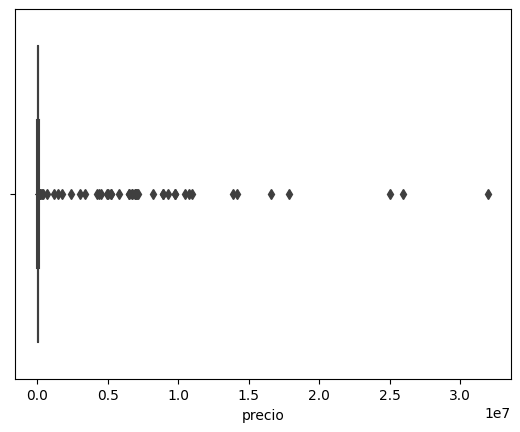

In [35]:
sns.boxplot(x=df['precio'])

<Axes: xlabel='tamanio'>

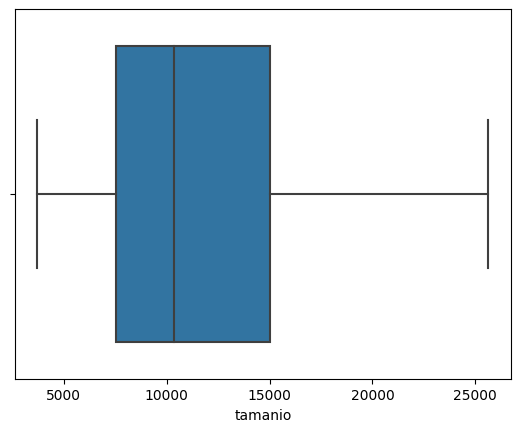

In [36]:
sns.boxplot(x=df['tamanio'], showfliers=False)

Observamos que el valor maximo de precio y tamanio esta muy por arriba del tercer percentil (75%) de los datos.

Al igual que en el precio minimo de las propiedades tambien existe un valor minimo muy por debajo del primer percentil (75%) por lo que concluimos que existen
outliers en los datos.

In [37]:
Q1 = df['precio'].quantile(0.25)
Q3 = df['precio'].quantile(0.75)
IQR = Q3 - Q1
outlier_threshold = 1.5  # Puedes ajustar este valor según tu criterio

# Filtra los outliers y crea un nuevo DataFrame sin ellos
df_sin_outliers = df[(df['precio'] >= Q1 - outlier_threshold * IQR) & (df['precio'] <= Q3 + outlier_threshold * IQR)]

In [38]:
len(df_sin_outliers)

495

Unicamente eliminamos 33 datos. 

In [39]:
df_sin_outliers.head(3)

,precio,tamanio,metros_cuadrados,num_baños,num_estacionamientos,num_recamaras,antiguedad,calle,mejor_coincidencia,MUNICIPIO,indice,indice_texto
0,35000,7111,1,1,1,1,1.0,Calle Lago Zurich 219,granada,MIGUEL HIDALGO,0.928227,Alto
1,90000,39943,399,5,3,3,4.0,Bosques de La Reforma,bosques de las lomas,CUAJIMALPA DE MORELOS,0.912393,Alto
2,90000,39943,399,5,3,3,4.0,Bosques de La Reforma,bosques de las lomas,MIGUEL HIDALGO,0.978901,Muy Alto


Revisamos ahora el grafico actualizado.

<Axes: xlabel='precio'>

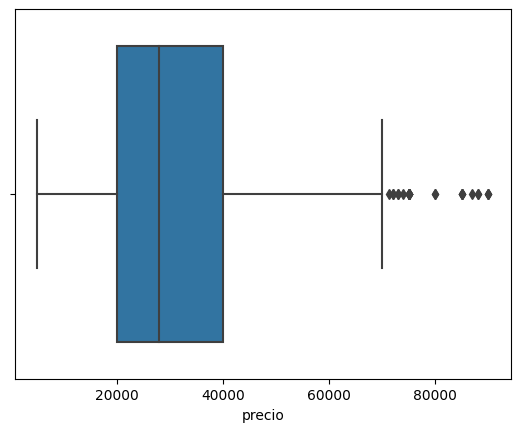

In [40]:
sns.boxplot(x=df_sin_outliers['precio'])

In [41]:
df = df_sin_outliers

Número de anuncios por alcaldia

In [42]:
df['MUNICIPIO'].value_counts()


MUNICIPIO
MIGUEL HIDALGO            159
CUAUHTEMOC                 90
CUAJIMALPA DE MORELOS      58
BENITO JUAREZ              49
AZCAPOTZALCO               48
COYOACAN                   20
ALVARO OBREGON             19
LA MAGDALENA CONTRERAS     18
IZTAPALAPA                 10
TLALPAN                     7
GUSTAVO A. MADERO           6
IZTACALCO                   5
VENUSTIANO CARRANZA         5
XOCHIMILCO                  1
Name: count, dtype: int64

Número de anuncios por colonia

In [43]:
df['mejor_coincidencia'].value_counts()

mejor_coincidencia
granada                             45
bosques de chapultepec (polanco)    44
cuauhtemoc                          36
bosques de las lomas                24
hipodromo condesa                   22
                                    ..
san rafael                           1
lomas de vista hermosa               1
nuevo renacimiento de axalco         1
sinatel                              1
insurgentes cuicuilco                1
Name: count, Length: 120, dtype: int64

Cambiaremos  el nombre de la columna mejor_coincidencia a colonia

In [44]:
df.rename(columns={'mejor_coincidencia': 'colonia'}, inplace=True)
df.rename(columns={'MUNICIPIO': 'municipio'}, inplace=True)

Reemplazar por 0 los valores nulos o NaN en la columna antiguedad esto debido a que por origen del scraping:


```python
caracteristicas = soup.find("ul", id="section-icon-features-property")

            for x in caracteristicas.find_all("li")[:5]:
                lista_caracteristicas.append(x.text)

            # Asegurémonos de que hay al menos 4 elementos en la lista de características
            if len(lista_caracteristicas) >= 4:
                metros_cuadrados = re.sub("[^0-9]", "", lista_caracteristicas[0])
                num_baños = re.sub("[^0-9]", "", lista_caracteristicas[1])
                num_estacionamientos = re.sub("[^0-9]", "", lista_caracteristicas[2])
                num_recamaras = re.sub("[^0-9]", "", lista_caracteristicas[3])
                antiguedad = re.sub("[^0-9]", "", lista_caracteristicas[4])

                # Ahora puedes utilizar estas variables como necesites
                print("Metros cuadrados:", metros_cuadrados)
                print("Número de baños:", num_baños)
                print("Número de estacionamientos:", num_estacionamientos)
                print("Número de recámaras:", num_recamaras)
                print("Antigüedad:", antiguedad) # Si no se encuentra valores numericos se queda un NaN

```

<center><img src="./imagenes/antiguedad.JPG" width="75%"></center>

Donde la query de busqueda:

- (https://www.inmuebles24.com/departamentos-en-renta-mas-de-1-bano-mas-de-1-estacionamiento-mas-de-1-metros-cuadrados-cubiertos-publicado-hace-menos-de-1-mes-hasta-50-anos.html)

Indica que siempre se buscaran propiedades que hayan registrado siempre la antiguedad en la plataforma. No hay valores faltantes.

In [45]:

df['antiguedad'].fillna(0, inplace=True)

Crear una tabla nueva con las columnas colonia,precio,tamanio , indice llamada df_mapa_alcaldia

In [46]:
df_mapa_alcaldia = df[['colonia','precio','indice','municipio', 'metros_cuadrados', 'num_baños' , 'num_estacionamientos', 'num_recamaras', 'antiguedad']]
df_mapa_alcaldia.head(3)

,colonia,precio,indice,municipio,metros_cuadrados,num_baños,num_estacionamientos,num_recamaras,antiguedad
0,granada,35000,0.928227,MIGUEL HIDALGO,1,1,1,1,1.0
1,bosques de las lomas,90000,0.912393,CUAJIMALPA DE MORELOS,399,5,3,3,4.0
2,bosques de las lomas,90000,0.978901,MIGUEL HIDALGO,399,5,3,3,4.0


Crearemos un __hot encoding__ para la columna colonia y agregarlo a la tabla df_mapa

In [47]:

df_mapa_alcaldia = df_mapa_alcaldia[['precio','indice','municipio', 'metros_cuadrados', 'num_baños' , 'num_estacionamientos', 'num_recamaras', 'antiguedad']]

df_mapa_alcaldia = pd.concat([df_mapa_alcaldia,pd.get_dummies(df_mapa_alcaldia['municipio'], prefix='municipio')],axis=1)
df_mapa_alcaldia.head(3)

,precio,indice,municipio,metros_cuadrados,num_baños,num_estacionamientos,num_recamaras,antiguedad,municipio_ALVARO OBREGON,municipio_AZCAPOTZALCO,...,municipio_CUAJIMALPA DE MORELOS,municipio_CUAUHTEMOC,municipio_GUSTAVO A. MADERO,municipio_IZTACALCO,municipio_IZTAPALAPA,municipio_LA MAGDALENA CONTRERAS,municipio_MIGUEL HIDALGO,municipio_TLALPAN,municipio_VENUSTIANO CARRANZA,municipio_XOCHIMILCO
0,35000,0.928227,MIGUEL HIDALGO,1,1,1,1,1.0,False,False,...,False,False,False,False,False,False,True,False,False,False
1,90000,0.912393,CUAJIMALPA DE MORELOS,399,5,3,3,4.0,False,False,...,True,False,False,False,False,False,False,False,False,False
2,90000,0.978901,MIGUEL HIDALGO,399,5,3,3,4.0,False,False,...,False,False,False,False,False,False,True,False,False,False


In [48]:
df_mapa_alcaldia = df_mapa_alcaldia.drop(['municipio'], axis=1)

Listo, tenemos completo nuestro dataset y ya podemos empezar a utilizarlo.

----------------------------------------


## EDA

Crear un heatmap para ver la correlacion entre las variables

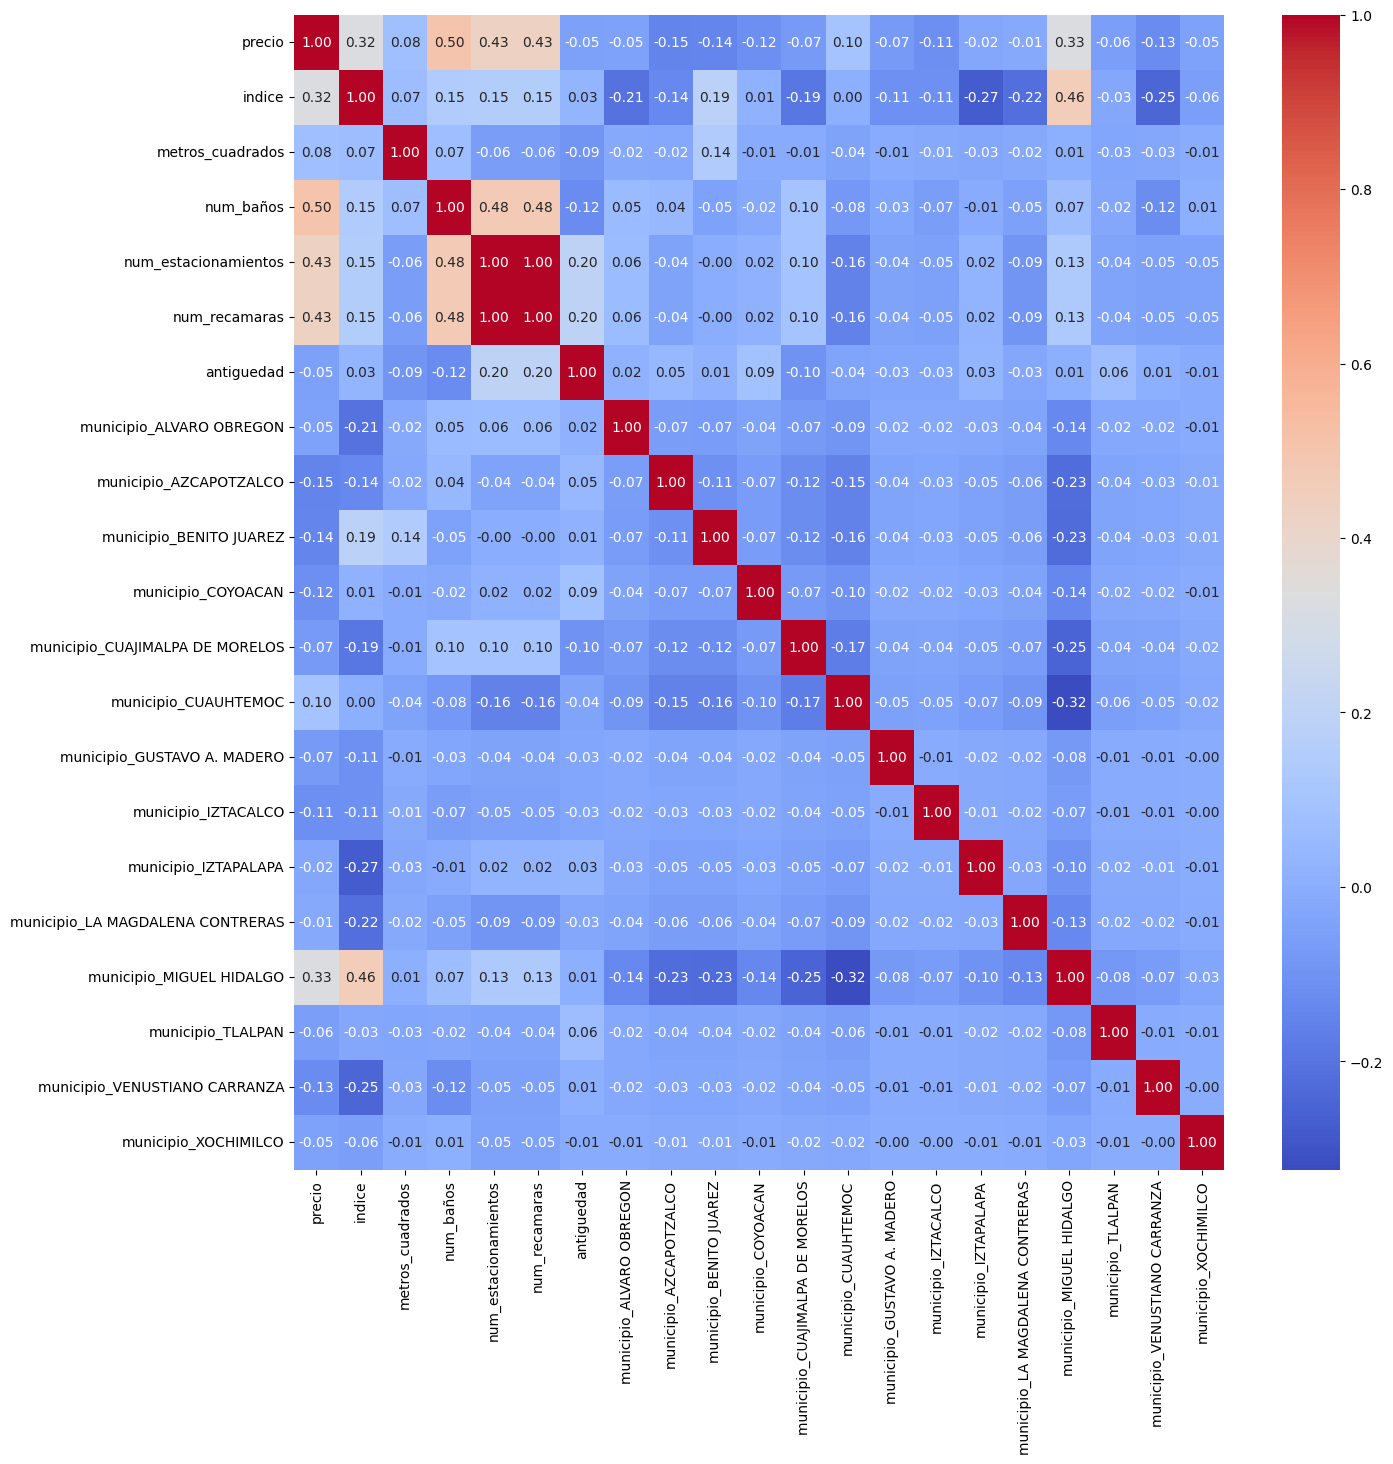

In [49]:
corr = df_mapa_alcaldia.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

¿Cuales son las variables que tienen mayor correlacion con el precio?

In [50]:
corr['precio'].sort_values(ascending=False)


precio                              1.000000
num_baños                           0.503848
num_estacionamientos                0.433461
num_recamaras                       0.433461
municipio_MIGUEL HIDALGO            0.327254
indice                              0.324639
municipio_CUAUHTEMOC                0.097368
metros_cuadrados                    0.076392
municipio_LA MAGDALENA CONTRERAS   -0.014515
municipio_IZTAPALAPA               -0.024821
municipio_ALVARO OBREGON           -0.048350
municipio_XOCHIMILCO               -0.049028
antiguedad                         -0.051535
municipio_TLALPAN                  -0.055424
municipio_CUAJIMALPA DE MORELOS    -0.073178
municipio_GUSTAVO A. MADERO        -0.074003
municipio_IZTACALCO                -0.114593
municipio_COYOACAN                 -0.116516
municipio_VENUSTIANO CARRANZA      -0.127583
municipio_BENITO JUAREZ            -0.144769
municipio_AZCAPOTZALCO             -0.148999
Name: precio, dtype: float64

* Precio y Num_Baños:

    Correlación positiva fuerte (0.503848): A medida que el número de baños aumenta, también tiende a aumentar el precio de la propiedad.

* Precio y Num_Estacionamientos:

    Correlación positiva fuerte (0.433461): Existe una relación positiva entre el número de estacionamientos y el precio. A medida que aumenta el número de estacionamientos, tiende a aumentar el precio.

* Precio y Num_Recamaras:

    Correlación positiva fuerte (0.433461): Similar al número de baños y estacionamientos, el número de recámaras también tiene una fuerte correlación positiva con el precio.

* Precio y Municipio_MIGUEL HIDALGO:

    Correlación positiva moderada (0.327254): La variable indicando si la propiedad se encuentra en Miguel Hidalgo tiene una correlación positiva moderada con el precio.

¿Cual es el local más caro y más barato?

In [51]:
# Supongamos que df_sin_outliers es tu DataFrame después de eliminar los outliers
fila_max_precio = df_mapa_alcaldia.loc[df_mapa_alcaldia['precio'].idxmax()]
fila_min_precio = df_mapa_alcaldia.loc[df_mapa_alcaldia['precio'].idxmin()]

print(f'El local con el precio máximo son:\n{fila_max_precio.values}')
print(f'El local con el precio mínimo son:\n{fila_min_precio.values}')

El local con el precio máximo son:
[90000 0.91239280465 399 5 3 3 4.0 False False False False True False
 False False False False False False False False]
El local con el precio mínimo son:
[5000 0.9577453127 217 2 2 2 2.0 False False False False False False False
 False False False True False False False]


Agregaremos a el dataframe una nueva columna llamada precio por metro cuadrado.

In [52]:
df_mapa_alcaldia['precio_m2'] = df_mapa_alcaldia['precio'] / df_mapa_alcaldia['metros_cuadrados']
df_sin_outliers['precio_m2'] = df_sin_outliers['precio'] / df_sin_outliers['metros_cuadrados']

¿Sera que el precio por metro cuadrado arroje nuevas conclusiones?

Crear un hot encoding para la columna colonia y agregarlo a la tabla df_mapa

In [53]:
df_mapa_alcaldia.head(3)

,precio,indice,metros_cuadrados,num_baños,num_estacionamientos,num_recamaras,antiguedad,municipio_ALVARO OBREGON,municipio_AZCAPOTZALCO,municipio_BENITO JUAREZ,...,municipio_CUAUHTEMOC,municipio_GUSTAVO A. MADERO,municipio_IZTACALCO,municipio_IZTAPALAPA,municipio_LA MAGDALENA CONTRERAS,municipio_MIGUEL HIDALGO,municipio_TLALPAN,municipio_VENUSTIANO CARRANZA,municipio_XOCHIMILCO,precio_m2
0,35000,0.928227,1,1,1,1,1.0,False,False,False,...,False,False,False,False,False,True,False,False,False,35000.00000
1,90000,0.912393,399,5,3,3,4.0,False,False,False,...,False,False,False,False,False,False,False,False,False,225.56391
2,90000,0.978901,399,5,3,3,4.0,False,False,False,...,False,False,False,False,False,True,False,False,False,225.56391


In [54]:
df_mapa_alcaldia.head(3)

,precio,indice,metros_cuadrados,num_baños,num_estacionamientos,num_recamaras,antiguedad,municipio_ALVARO OBREGON,municipio_AZCAPOTZALCO,municipio_BENITO JUAREZ,...,municipio_CUAUHTEMOC,municipio_GUSTAVO A. MADERO,municipio_IZTACALCO,municipio_IZTAPALAPA,municipio_LA MAGDALENA CONTRERAS,municipio_MIGUEL HIDALGO,municipio_TLALPAN,municipio_VENUSTIANO CARRANZA,municipio_XOCHIMILCO,precio_m2
0,35000,0.928227,1,1,1,1,1.0,False,False,False,...,False,False,False,False,False,True,False,False,False,35000.00000
1,90000,0.912393,399,5,3,3,4.0,False,False,False,...,False,False,False,False,False,False,False,False,False,225.56391
2,90000,0.978901,399,5,3,3,4.0,False,False,False,...,False,False,False,False,False,True,False,False,False,225.56391


Crear un heatmap para ver la correlacion entre las variables

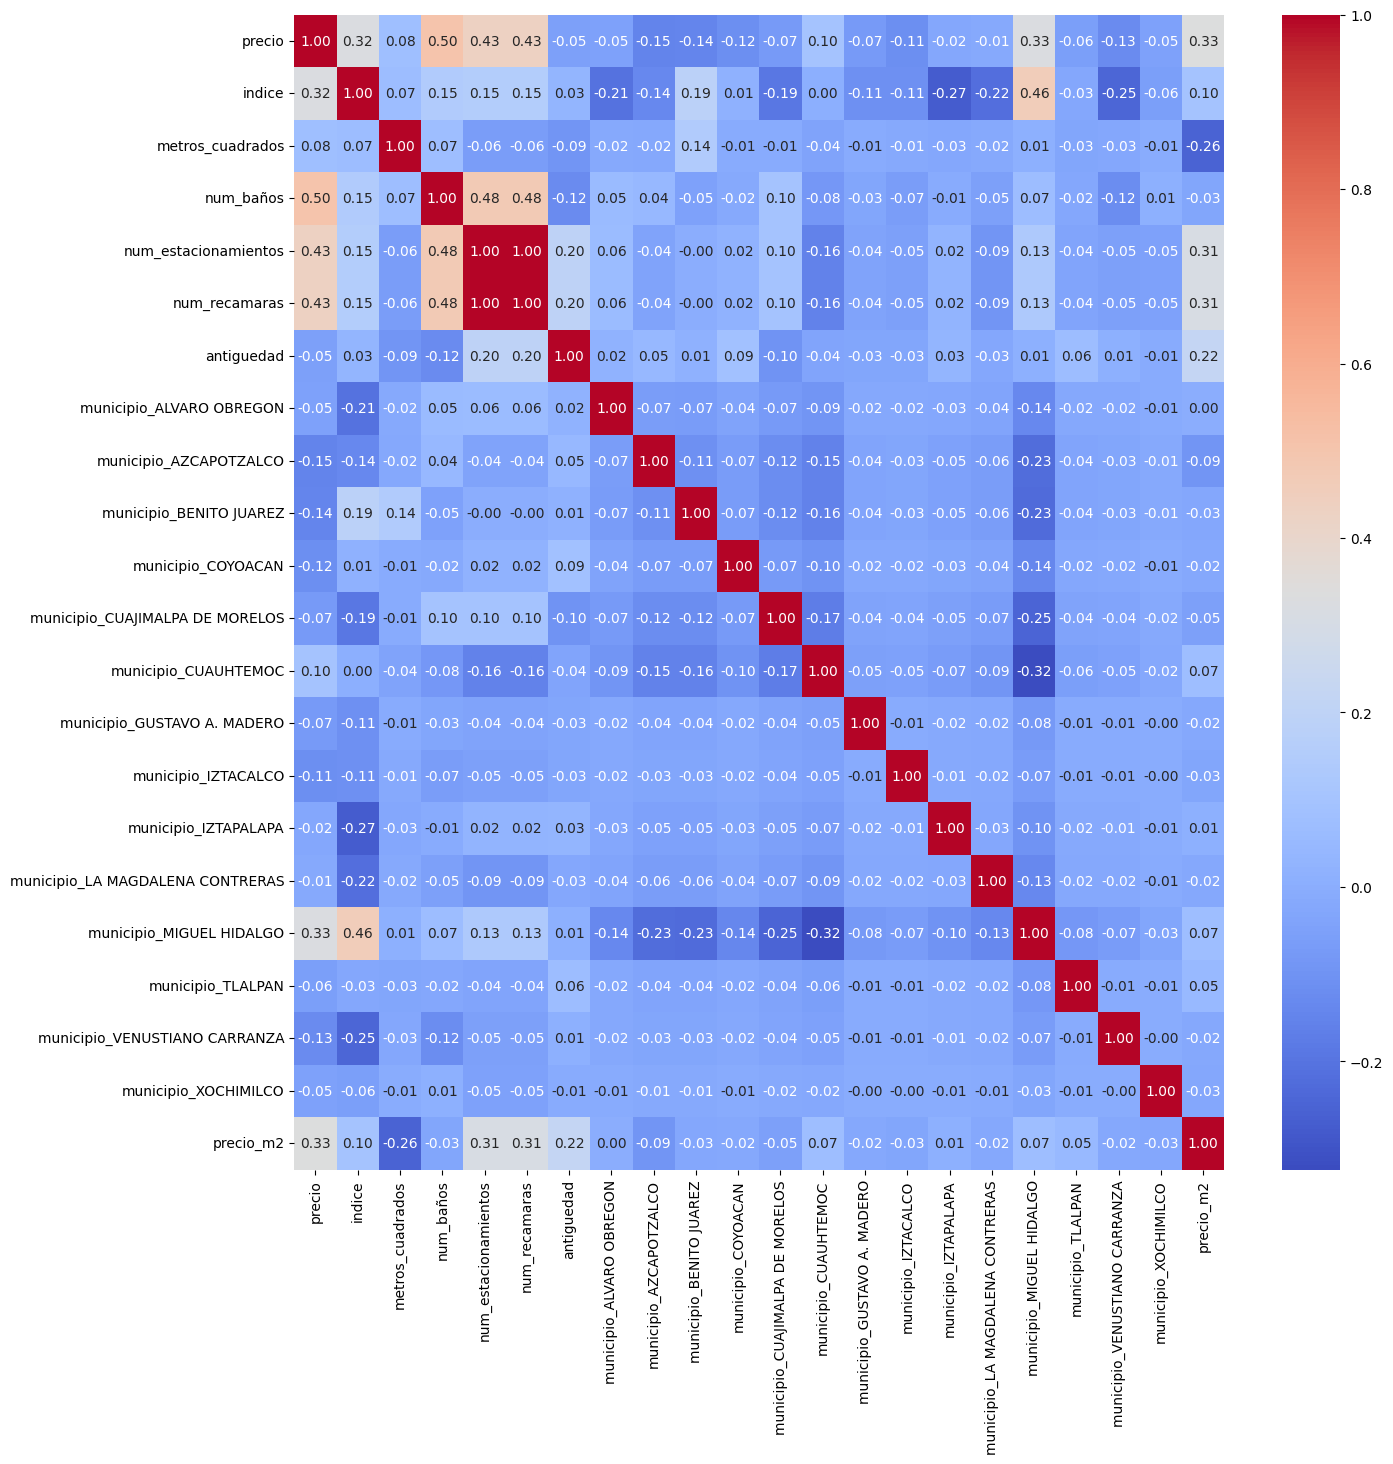

In [55]:
corr = df_mapa_alcaldia.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

In [56]:
corr['precio_m2'].sort_values(ascending=False)

precio_m2                           1.000000
precio                              0.333078
num_estacionamientos                0.310711
num_recamaras                       0.310711
antiguedad                          0.218881
indice                              0.098836
municipio_CUAUHTEMOC                0.073815
municipio_MIGUEL HIDALGO            0.070496
municipio_TLALPAN                   0.051403
municipio_IZTAPALAPA                0.010717
municipio_ALVARO OBREGON            0.001178
municipio_LA MAGDALENA CONTRERAS   -0.019827
municipio_COYOACAN                 -0.020781
municipio_VENUSTIANO CARRANZA      -0.020937
municipio_GUSTAVO A. MADERO        -0.023946
municipio_BENITO JUAREZ            -0.026329
municipio_XOCHIMILCO               -0.026666
num_baños                          -0.030400
municipio_IZTACALCO                -0.033916
municipio_CUAJIMALPA DE MORELOS    -0.051871
municipio_AZCAPOTZALCO             -0.093063
metros_cuadrados                   -0.255622
Name: prec

* __Precio_m2 y Num_Estacionamientos:__

    Correlación positiva moderada (0.333): Hay una correlación positiva moderada entre el precio por metro cuadrado y el número de estacionamientos. Esto indica que propiedades con un precio por metro cuadrado más alto tienden a tener un mayor número de estacionamientos.

* __Precio_m2 y Num_Recamaras:__

    Correlación positiva moderada (0.310711): Similar al número de estacionamientos, hay una correlación positiva moderada entre el precio por metro cuadrado y el número de recámaras.
    
* __Precio_m2 y Antigüedad:__

    Correlación positiva moderada (0.218881): Existe una correlación moderada positiva entre el precio por metro cuadrado y la antigüedad de la propiedad. Esto sugiere que propiedades más antiguas tienden a tener un precio por metro cuadrado más alto.

In [57]:
df_mapa_alcaldia.head(3)

,precio,indice,metros_cuadrados,num_baños,num_estacionamientos,num_recamaras,antiguedad,municipio_ALVARO OBREGON,municipio_AZCAPOTZALCO,municipio_BENITO JUAREZ,...,municipio_CUAUHTEMOC,municipio_GUSTAVO A. MADERO,municipio_IZTACALCO,municipio_IZTAPALAPA,municipio_LA MAGDALENA CONTRERAS,municipio_MIGUEL HIDALGO,municipio_TLALPAN,municipio_VENUSTIANO CARRANZA,municipio_XOCHIMILCO,precio_m2
0,35000,0.928227,1,1,1,1,1.0,False,False,False,...,False,False,False,False,False,True,False,False,False,35000.00000
1,90000,0.912393,399,5,3,3,4.0,False,False,False,...,False,False,False,False,False,False,False,False,False,225.56391
2,90000,0.978901,399,5,3,3,4.0,False,False,False,...,False,False,False,False,False,True,False,False,False,225.56391


Cambiar nombre de municipio a alcaldia para su mejor manipulacion.

In [58]:
df_sin_outliers.rename(columns={'municipio': 'alcaldia'}, inplace=True)

Precios de renta por metro cuadrado en la CDMX por alcaldia 

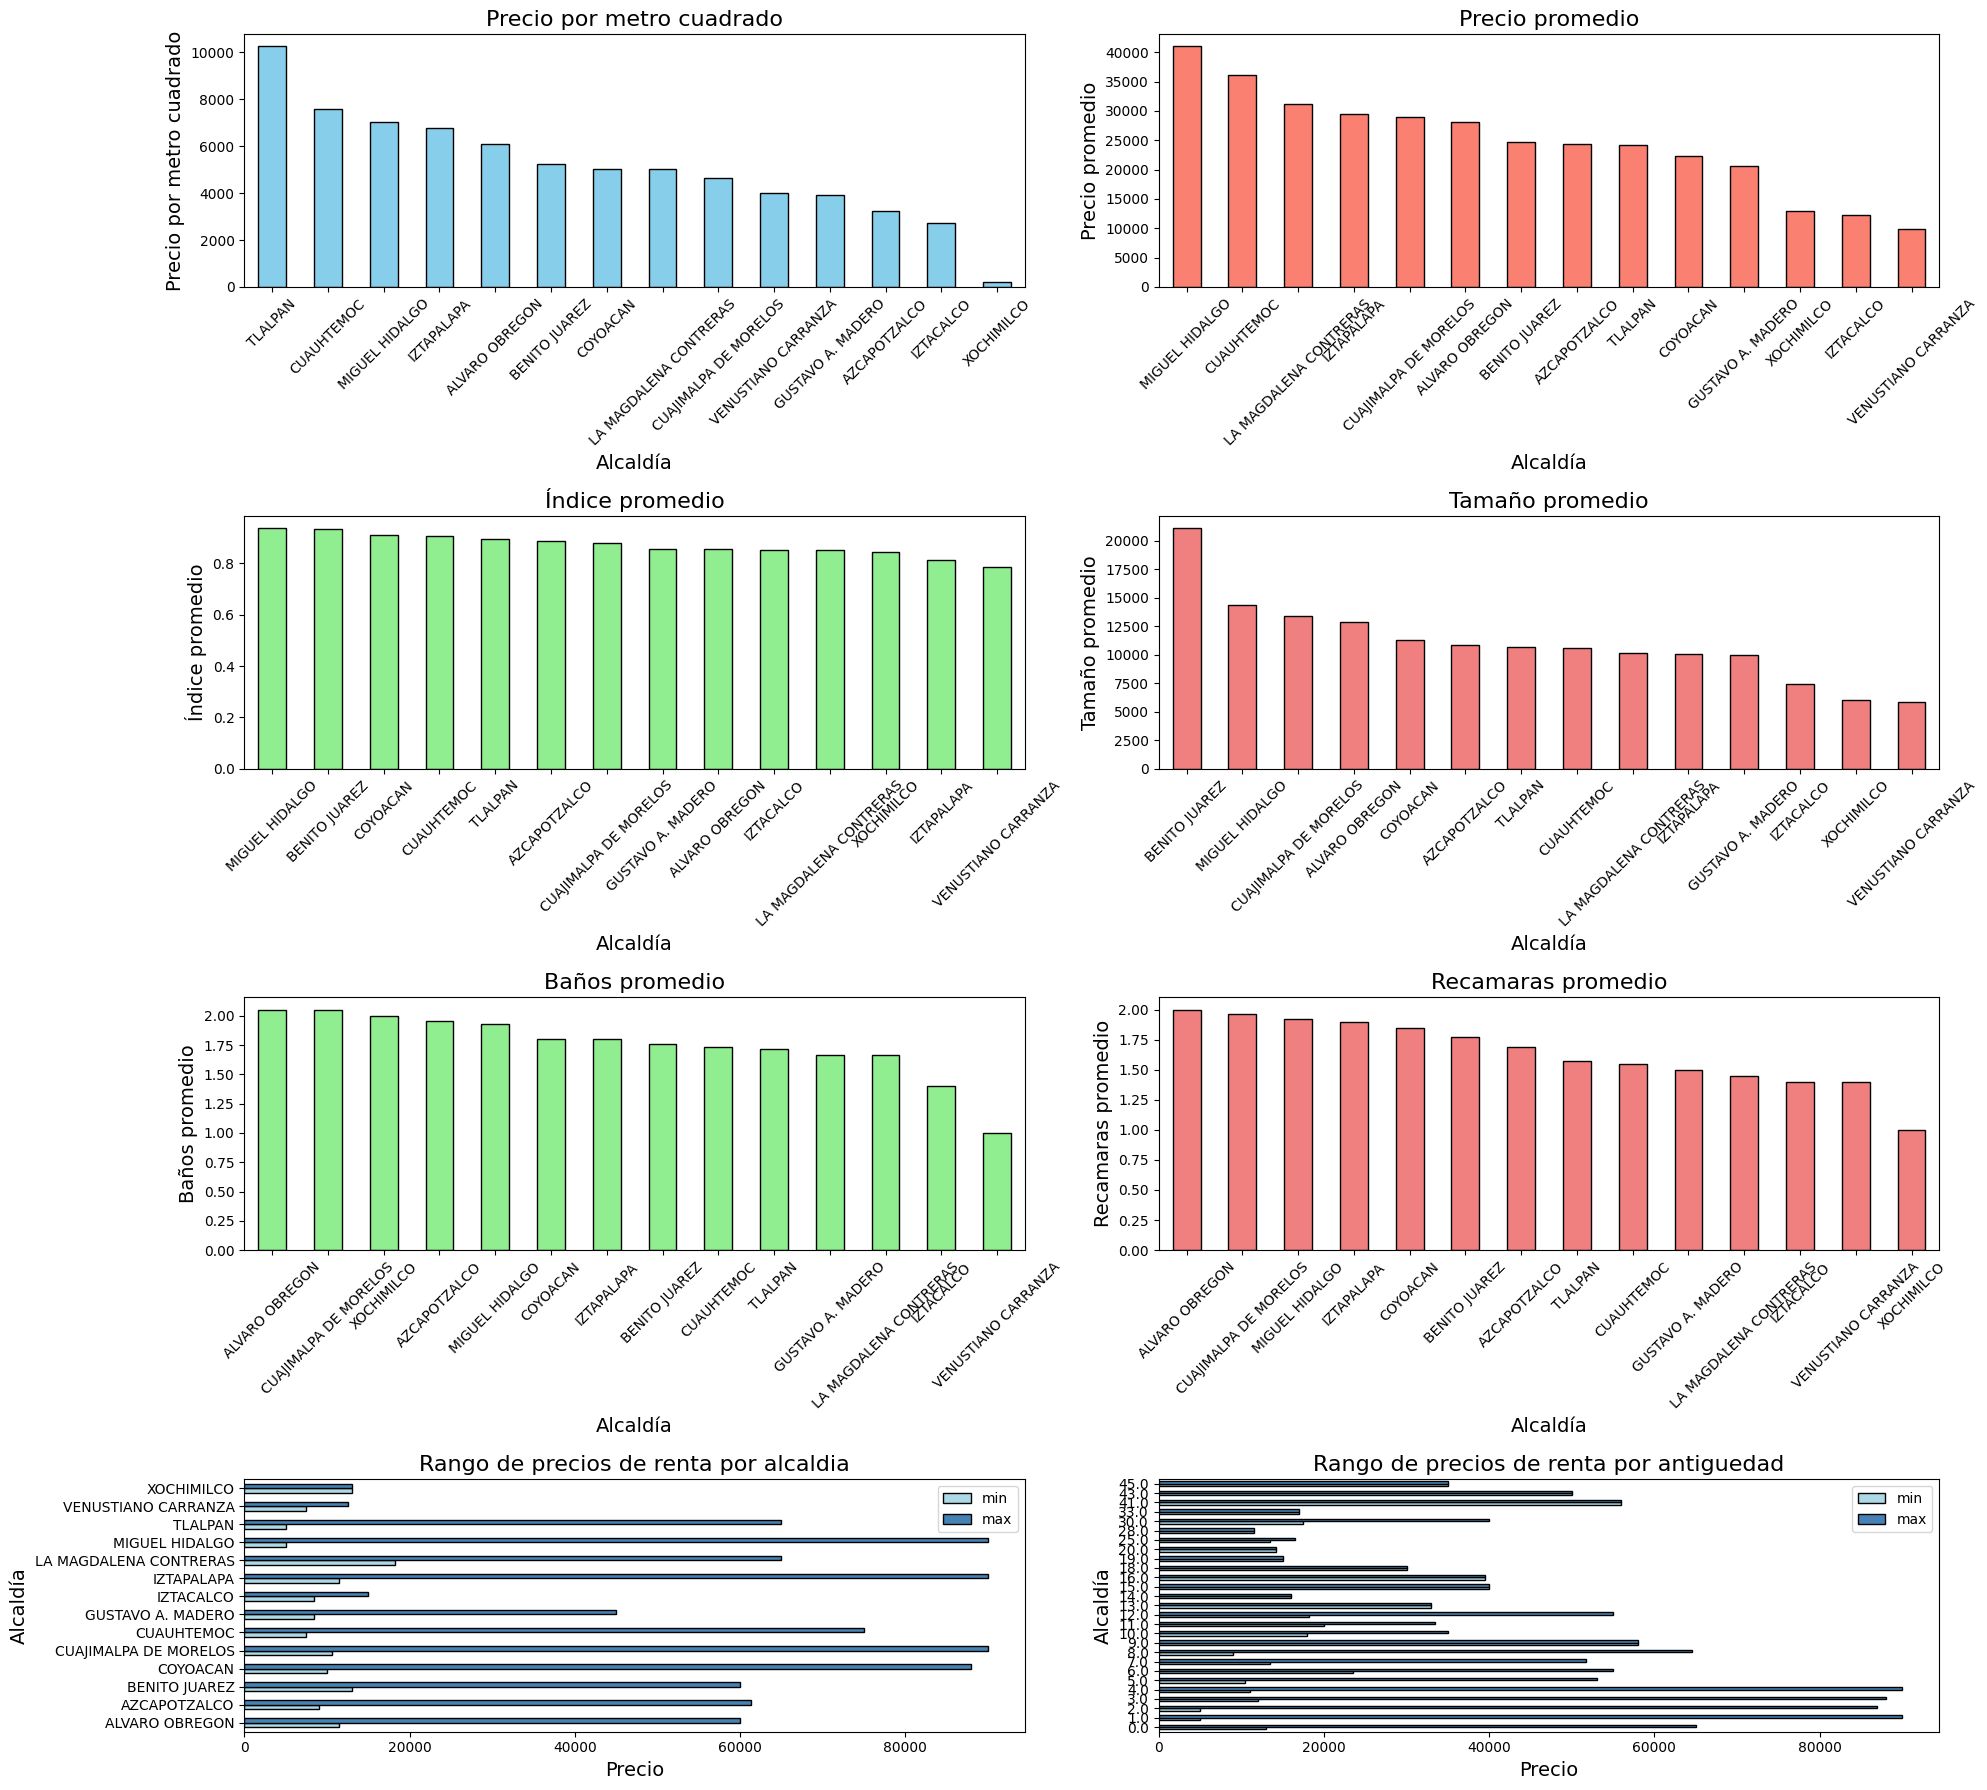

In [72]:

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 18))

df_sin_outliers.groupby('alcaldia')['precio_m2'].mean().sort_values(ascending=False).plot(kind='bar', ax=axes[0, 0], color='skyblue', edgecolor='black')
axes[0, 0].set_title('Precio por metro cuadrado', fontsize=16)
axes[0, 0].set_xlabel('Alcaldía', fontsize=14)
axes[0, 0].set_ylabel('Precio por metro cuadrado', fontsize=14)
axes[0, 0].tick_params(axis='x', labelrotation=45)

df_sin_outliers.groupby('alcaldia')['precio'].mean().sort_values(ascending=False).plot(kind='bar', ax=axes[0, 1], color='salmon', edgecolor='black')
axes[0, 1].set_title('Precio promedio', fontsize=16)
axes[0, 1].set_xlabel('Alcaldía', fontsize=14)
axes[0, 1].set_ylabel('Precio promedio', fontsize=14)
axes[0, 1].tick_params(axis='x', labelrotation=45)

df_sin_outliers.groupby('alcaldia')['indice'].mean().sort_values(ascending=False).plot(kind='bar', ax=axes[1, 0], color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Índice promedio', fontsize=16)
axes[1, 0].set_xlabel('Alcaldía', fontsize=14)
axes[1, 0].set_ylabel('Índice promedio', fontsize=14)
axes[1, 0].tick_params(axis='x', labelrotation=45)

df_sin_outliers.groupby('alcaldia')['tamanio'].mean().sort_values(ascending=False).plot(kind='bar', ax=axes[1, 1], color='lightcoral', edgecolor='black')
axes[1, 1].set_title('Tamaño promedio', fontsize=16)
axes[1, 1].set_xlabel('Alcaldía', fontsize=14)
axes[1, 1].set_ylabel('Tamaño promedio', fontsize=14)
axes[1, 1].tick_params(axis='x', labelrotation=45)

df_sin_outliers.groupby('alcaldia')['num_baños'].mean().sort_values(ascending=False).plot(kind='bar', ax=axes[2, 0], color='lightgreen', edgecolor='black')
axes[2, 0].set_title('Baños promedio', fontsize=16)
axes[2, 0].set_xlabel('Alcaldía', fontsize=14)
axes[2, 0].set_ylabel('Baños promedio', fontsize=14)
axes[2, 0].tick_params(axis='x', labelrotation=45)

df_sin_outliers.groupby('alcaldia')['num_recamaras'].mean().sort_values(ascending=False).plot(kind='bar', ax=axes[2, 1], color='lightcoral', edgecolor='black')
axes[2, 1].set_title('Recamaras promedio', fontsize=16)
axes[2, 1].set_xlabel('Alcaldía', fontsize=14)
axes[2, 1].set_ylabel('Recamaras promedio', fontsize=14)
axes[2, 1].tick_params(axis='x', labelrotation=45)

df_sin_outliers.groupby('alcaldia')['precio'].agg(['min', 'max']).plot(kind='barh', ax=axes[3, 0], color=['lightblue', 'steelblue'], edgecolor='black')
axes[3, 0].set_title('Rango de precios de renta por alcaldia', fontsize=16)
axes[3, 0].set_xlabel('Precio', fontsize=14)
axes[3, 0].set_ylabel('Alcaldía', fontsize=14)

df_sin_outliers.groupby('antiguedad')['precio'].agg(['min', 'max']).plot(kind='barh', ax=axes[3, 1], color=['lightblue', 'steelblue'], edgecolor='black')
axes[3, 1].set_title('Rango de precios de renta por antiguedad', fontsize=16)
axes[3, 1].set_xlabel('Precio', fontsize=14)
axes[3, 1].set_ylabel('Alcaldía', fontsize=14)

plt.tight_layout()

plt.show()


### Análisis de Datos sobre Propiedades en la Ciudad de México

En la primera gráfica, se observa que el precio por metro cuadrado de las propiedades obtenidas en el scraping es más alto en Tlalpan y más bajo en Xochimilco. Además, el precio promedio más alto se encuentra en la alcaldía Miguel Hidalgo, mientras que el más bajo está en Venustiano Carranza.

El índice de desarrollo se mantiene estable en general. Sin embargo, la colonia con el nivel de índice de desarrollo específico no ha sido proporcionada.

En cuanto al tamaño de las propiedades, se observa que son más grandes en Benito Juárez, disminuyendo significativamente hasta llegar a Venustiano Carranza.

El número promedio de baños es de 2 en Álvaro Obregón, disminuyendo a 1 en Venustiano Carranza, posiblemente relacionado con el tamaño de la propiedad.

Las recámaras promedio también son 2 en Álvaro Obregón, disminuyendo hasta 1 en Xochimilco.

Un dato interesante es la variabilidad en los precios de renta en Miguel Hidalgo, que oscila entre valores muy económicos y propiedades considerablemente caras. En Xochimilco, las rentas son más uniformes, al igual que en Venustiano Carranza.

En los rangos de precio y antigüedad máxima, se observa que las propiedades nuevas son más caras que las propiedades más antiguas, indicando una relación significativa entre la antigüedad y el costo. Este hallazgo sugiere que las propiedades recientes tienden a tener un valor más elevado en comparación con las más antiguas.

Este análisis proporciona una visión detallada de las tendencias y características de las propiedades en diferentes alcaldías de la Ciudad de México, respaldado por datos recopilados durante el scraping.

---------------------------------

In [73]:
df_mapa_alcaldia.head(3)

,precio,indice,metros_cuadrados,num_baños,num_estacionamientos,num_recamaras,antiguedad,municipio_ALVARO OBREGON,municipio_AZCAPOTZALCO,municipio_BENITO JUAREZ,...,municipio_CUAUHTEMOC,municipio_GUSTAVO A. MADERO,municipio_IZTACALCO,municipio_IZTAPALAPA,municipio_LA MAGDALENA CONTRERAS,municipio_MIGUEL HIDALGO,municipio_TLALPAN,municipio_VENUSTIANO CARRANZA,municipio_XOCHIMILCO,precio_m2
0,35000,92.822684,1,1,1,1,1.0,False,False,False,...,False,False,False,False,False,True,False,False,False,35000.00000
1,90000,91.239280,399,5,3,3,4.0,False,False,False,...,False,False,False,False,False,False,False,False,False,225.56391
2,90000,97.890077,399,5,3,3,4.0,False,False,False,...,False,False,False,False,False,True,False,False,False,225.56391


In [74]:
#multiplicar el indice por 100
df_mapa_alcaldia['indice'] = df_mapa_alcaldia['indice'] * 100

df_modelo = df_mapa_alcaldia

-----------------------------------

### Prediccion

Ordinary Least Squares (OLS) es un enfoque clásico para modelar la relación lineal entre las variables independientes y la variable dependiente.

In [75]:
import pandas as pd
import statsmodels.api as sm


X = df_modelo[['metros_cuadrados', 'num_baños', 'num_estacionamientos', 'num_recamaras', 'antiguedad' , 'indice']]
y = df_modelo['precio']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 precio   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     55.65
Date:                Thu, 11 Jan 2024   Prob (F-statistic):           9.37e-46
Time:                        17:51:37   Log-Likelihood:                -5437.9
No. Observations:                 495   AIC:                         1.089e+04
Df Residuals:                     489   BIC:                         1.091e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -7.265e+04 

<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <meta name="viewport" content="width=device-width, initial-scale=1.0">
  <title>Resultados del Modelo - Detalles</title>
  <style>
    body {
      font-family: Arial, sans-serif;
      margin: 20px;
    }
    h2 {
      color: #333;
    }
    p {
      margin: 10px 0;
    }
  </style>
</head>
<body>

  <h2>Detalles del Modelo</h2>

  <p><strong>R-squared (R²):</strong> 0.363</p>
  <ul>
    <li>R-squared mide la proporción de la varianza en la variable dependiente que es explicada por el modelo. En este caso, el 36.3% de la variabilidad en el precio se explica por las variables independientes en el modelo.</li>
    <li>Adj. R-squared: 0.356 - El R-cuadrado ajustado tiene en cuenta el número de variables en el modelo, ajustando el R-cuadrado por la complejidad del modelo. Este valor es similar al R-cuadrado y muestra cómo el modelo se ajusta a los datos.</li>
    <li>F-statistic: 55.65 - El F-statistic es una prueba de significancia global del modelo. Un valor grande con un p-value pequeño indica que al menos una variable independiente está influyendo significativamente en la variable dependiente.</li>
    <li>Prob (F-statistic): 9.37e-46 - El p-value asociado al F-statistic. Un valor pequeño (en este caso, muy cercano a cero) sugiere que el modelo en su conjunto es significativo.</li>
  </ul>

  <h3>Coeficientes:</h3>
  <ul>
    <li><strong>const:</strong> -7.265e+04 - Este es el valor estimado del precio cuando todas las variables independientes son cero.</li>
    <li><strong>metros_cuadrados:</strong> 4.28 - Por cada unidad adicional en metros cuadrados, se espera un aumento de 4.28 en el precio.</li>
    <li><strong>num_baños:</strong> 8467.9887 - Cada baño adicional se asocia con un aumento de 8467.9887 en el precio.</li>
    <li><strong>num_estacionamientos:</strong> 3165.9723 - Cada estacionamiento adicional se asocia con un aumento de 3165.9723 en el precio.</li>
    <li><strong>num_recamaras:</strong> 3165.9723 - Cada recámara adicional se asocia con un aumento de 3165.9723 en el precio.</li>
    <li><strong>antiguedad:</strong> -207.9308 - Cada año adicional de antigüedad se asocia con una disminución de 207.9308 en el precio.</li>
    <li><strong>indice:</strong> 432.8902 - Cada valor adicional del índice se asocia a un aumento de 432.8902 en el precio.</li>
  </ul>

</body>
</html>


#### Evaluaremos diferentes modelos para regresion lineal con la finalidad de elegir el mejor.

Pero antes, generaremos datos sinteticos para aumentar la cantidad de datos sin afectar sulos hallazgos

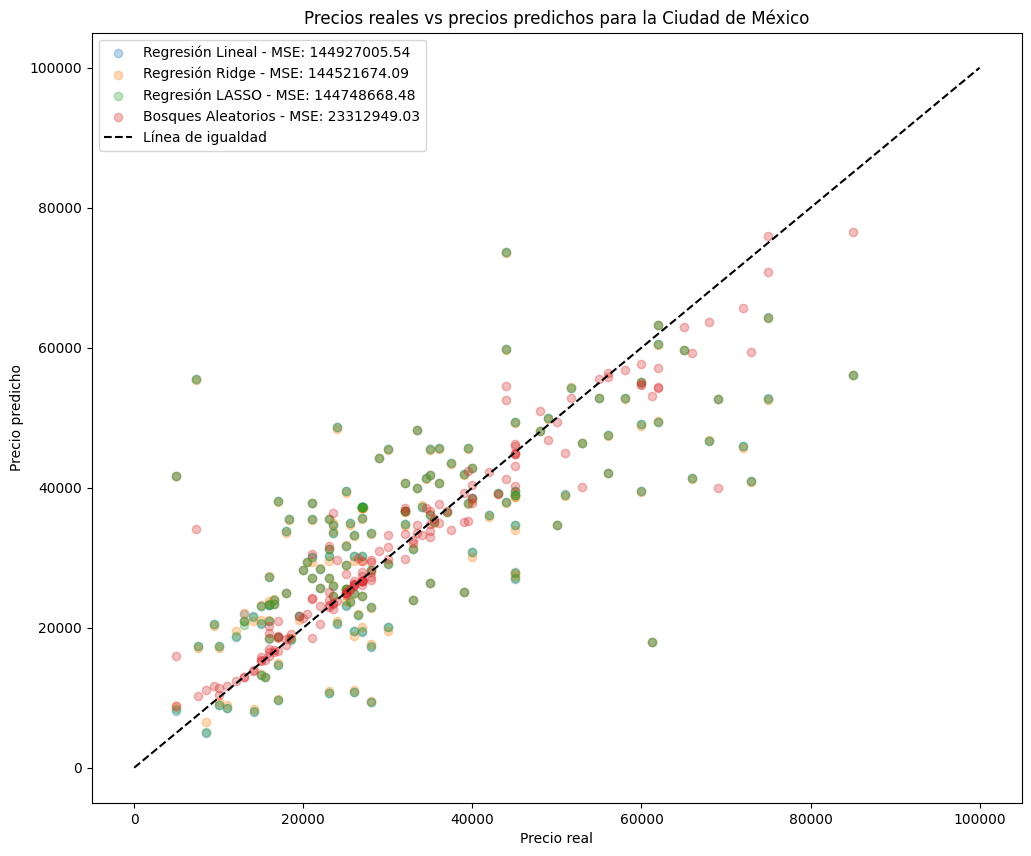

In [76]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np


X_encoded = df_modelo.drop(['precio'], axis=1)   
y_encoded = df_modelo['precio']

X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(X_encoded, y_encoded, test_size=0.3, random_state=43)

models = {
    'Regresión Lineal': LinearRegression(),
    'Regresión Ridge': Ridge(),
    'Regresión LASSO': Lasso(),
    'Bosques Aleatorios': RandomForestRegressor()
}

predictions_dict = {}

for model_name, model in models.items():
    model.fit(X_train_encoded, y_train_encoded)
    predictions_encoded = model.predict(X_test_encoded)
    predictions_dict[model_name] = predictions_encoded

plt.figure(figsize=(12, 10))

for model_name, predictions_encoded in predictions_dict.items():
    mse_encoded = mean_squared_error(y_test_encoded, predictions_encoded)
    plt.scatter(y_test_encoded, predictions_encoded, alpha=0.3, label=f'{model_name} - MSE: {mse_encoded:.2f}')

plt.plot(np.linspace(0, 100000, 1000), np.linspace(0, 100000, 1000), linestyle='--', color='black', label='Línea de igualdad')
plt.xlabel('Precio real')
plt.ylabel('Precio predicho')
plt.title('Precios reales vs precios predichos para la Ciudad de México')
plt.legend()
plt.show()


In [77]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

metrics_df = pd.DataFrame(index=models.keys(), columns=['MSE', 'MAE', 'R²'])

for model_name, predictions_encoded in predictions_dict.items():
    mse = mean_squared_error(y_test_encoded, predictions_encoded)
    mae = mean_absolute_error(y_test_encoded, predictions_encoded)
    r2 = r2_score(y_test_encoded, predictions_encoded)
    
    metrics_df.loc[model_name] = [mse, mae, r2]

print(metrics_df)


                                 MSE          MAE        R²
Regresión Lineal    144927005.535857  8945.282834  0.482265
Regresión Ridge     144521674.087173  8911.041381  0.483713
Regresión LASSO     144748668.478734  8935.943802  0.482902
Bosques Aleatorios   23312949.030705  2577.631342  0.916717


<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <meta name="viewport" content="width=device-width, initial-scale=1.0">
  <title>Resultados del Modelo</title>
  <style>
    body {
      font-family: Arial, sans-serif;
      margin: 20px;
    }
    h2 {
      color: #333;
    }
    table {
      font-family: Arial, sans-serif;
      border-collapse: collapse;
      width: 80%;
      margin: 20px auto;
    }
    th, td {
      border: 1px solid #dddddd;
      text-align: left;
      padding: 8px;
    }
    th {
      background-color: #f2f2f2;
    }
  </style>
</head>
<body>

  <h2>Resultados del Modelo</h2>

  <table>
    <tr>
      <th>Modelo</th>
      <th>MSE</th>
      <th>MAE</th>
      <th>R²</th>
    </tr>
    <tr>
      <td>Regresión Lineal</td>
      <td>144927005.54</td>
      <td>8945.28</td>
      <td>0.4823</td>
    </tr>
    <tr>
      <td>Regresión Ridge</td>
      <td>144521674.09</td>
      <td>8911.04</td>
      <td>0.4837</td>
    </tr>
    <tr>
      <td>Regresión LASSO</td>
      <td>144748668.48</td>
      <td>8935.94</td>
      <td>0.4829</td>
    </tr>
    <tr>
      <td>Bosques Aleatorios</td>
      <td>25807823.94</td>
      <td>2767.47</td>
      <td>0.9078</td>
    </tr>
  </table>

  <h2>Interpretación</h2>
  <ul>
    <li>En términos de MSE, un valor más bajo indica un mejor rendimiento.</li>
    <li>En términos de MAE, un valor más bajo indica un mejor rendimiento.</li>
    <li>En cuanto al coeficiente de determinación R², un valor más alto indica un mejor ajuste.</li>
    <li>El modelo de Bosques Aleatorios parece ser el mejor, ya que tiene el MSE más bajo, el MAE más bajo y el R² más alto.</li>
  </ul>

  <h2>Conclusión</h2>
  <p>Basándonos en estas métricas, el modelo de Bosques Aleatorios parece ser el mejor de los modelos evaluados.</p>

</body>
</html>


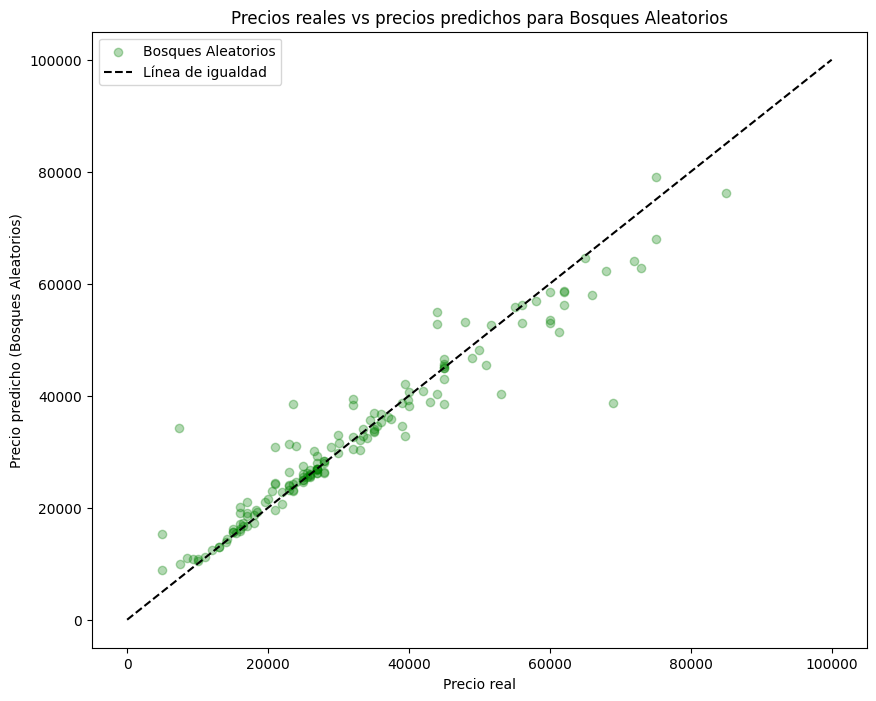

In [78]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np

# Crear y entrenar un modelo de Bosques Aleatorios
random_forest_model = RandomForestRegressor()
random_forest_model.fit(X_train_encoded, y_train_encoded)

# Realizar predicciones en el conjunto de prueba
predictions_random_forest = random_forest_model.predict(X_test_encoded)

# Graficar precios reales vs precios predichos
plt.figure(figsize=(10, 8))
plt.scatter(y_test_encoded, predictions_random_forest, alpha=0.3 , color='green', label='Bosques Aleatorios' )
plt.plot(np.linspace(0, 100000, 1000), np.linspace(0, 100000, 1000), linestyle='--', color='black', label='Línea de igualdad')
plt.xlabel('Precio real')
plt.ylabel('Precio predicho (Bosques Aleatorios)')
plt.title('Precios reales vs precios predichos para Bosques Aleatorios')
plt.legend()
plt.show()


##### Analisis a metros cuadradados 

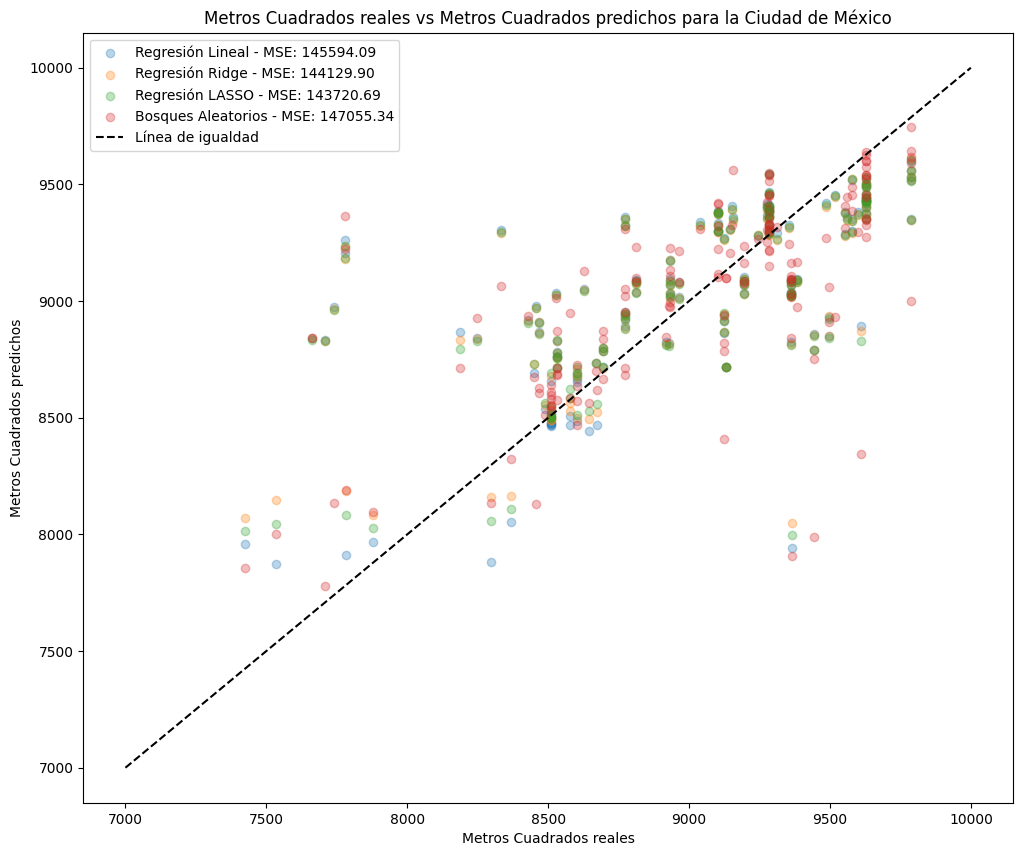

In [79]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Suponiendo que tu DataFrame se llama df_modelo y la variable objetivo es 'metros_cuadrados'
X_encoded = df_modelo.drop(['indice'], axis=1)
y_encoded = df_modelo['indice']

X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(X_encoded, y_encoded, test_size=0.3, random_state=42)

models = {
    'Regresión Lineal': LinearRegression(),
    'Regresión Ridge': Ridge(),
    'Regresión LASSO': Lasso(),
    'Bosques Aleatorios': RandomForestRegressor()
}

predictions_dict = {}

for model_name, model in models.items():
    model.fit(X_train_encoded, y_train_encoded)
    predictions_encoded = model.predict(X_test_encoded)
    predictions_dict[model_name] = predictions_encoded

plt.figure(figsize=(12, 10))

for model_name, predictions_encoded in predictions_dict.items():
    mse_encoded = mean_squared_error(y_test_encoded, predictions_encoded)
    plt.scatter(y_test_encoded, predictions_encoded, alpha=0.3, label=f'{model_name} - MSE: {mse_encoded:.2f}')

plt.plot(np.linspace(7000, 10000, 20000), np.linspace(7000, 10000, 20000), linestyle='--', color='black', label='Línea de igualdad')
plt.xlabel('Metros Cuadrados reales')
plt.ylabel('Metros Cuadrados predichos')
plt.title('Metros Cuadrados reales vs Metros Cuadrados predichos para la Ciudad de México')
plt.legend()
plt.show()


In [80]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

metrics_df = pd.DataFrame(index=models.keys(), columns=['MSE', 'MAE', 'R²'])

for model_name, predictions_encoded in predictions_dict.items():
    mse = mean_squared_error(y_test_encoded, predictions_encoded)
    mae = mean_absolute_error(y_test_encoded, predictions_encoded)
    r2 = r2_score(y_test_encoded, predictions_encoded)
    
    metrics_df.loc[model_name] = [mse, mae, r2]

print(metrics_df)


                              MSE         MAE        R²
Regresión Lineal    145594.085101  267.828486  0.473367
Regresión Ridge     144129.902525  266.977928  0.478664
Regresión LASSO     143720.691509   265.69374  0.480144
Bosques Aleatorios  147055.344113  248.896107  0.468082


<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <meta name="viewport" content="width=device-width, initial-scale=1.0">
  <title>Resultados del Modelo</title>
  <style>
    table {
      font-family: Arial, sans-serif;
      border-collapse: collapse;
      width: 80%;
      margin: 20px auto;
    }
    th, td {
      border: 1px solid #dddddd;
      text-align: left;
      padding: 8px;
    }
    th {
      background-color: #f2f2f2;
    }
  </style>
</head>
<body>

  <h2>Resultados del Modelo</h2>

  <table>
    <tr>
      <th>Modelo</th>
      <th>MSE</th>
      <th>MAE</th>
      <th>R²</th>
    </tr>
    <tr>
      <td>Regresión Lineal</td>
      <td>145594.09</td>
      <td>267.83</td>
      <td>0.4734</td>
    </tr>
    <tr>
      <td>Regresión Ridge</td>
      <td>144129.90</td>
      <td>266.98</td>
      <td>0.4787</td>
    </tr>
    <tr>
      <td>Regresión LASSO</td>
      <td>143720.69</td>
      <td>265.69</td>
      <td>0.4801</td>
    </tr>
    <tr>
      <td>Bosques Aleatorios</td>
      <td>147055.34</td>
      <td>248.90</td>
      <td>0.4681</td>
    </tr>
  </table>

</body>
</html>


Elección del Mejor Modelo:

- La elección del mejor modelo depende de las metas específicas del análisis.
- Si se valora la capacidad predictiva, la Regresión LASSO parece ser la opción más sólida, ya que tiene el MSE más bajo.
- Sin embargo, la elección final también puede depender de otros factores, como la interpretabilidad del modelo y la complejidad computacional.


La Regresión LASSO podría considerarse el mejor modelo en función de las métricas proporcionadas.

--------------------------------

#### Seleccionar solo la alcaldia Miguel Hidalgo

In [68]:
df_modelo_miguel_hidalgo = df_mapa_alcaldia[df_mapa_alcaldia['municipio_MIGUEL HIDALGO'] == 1]

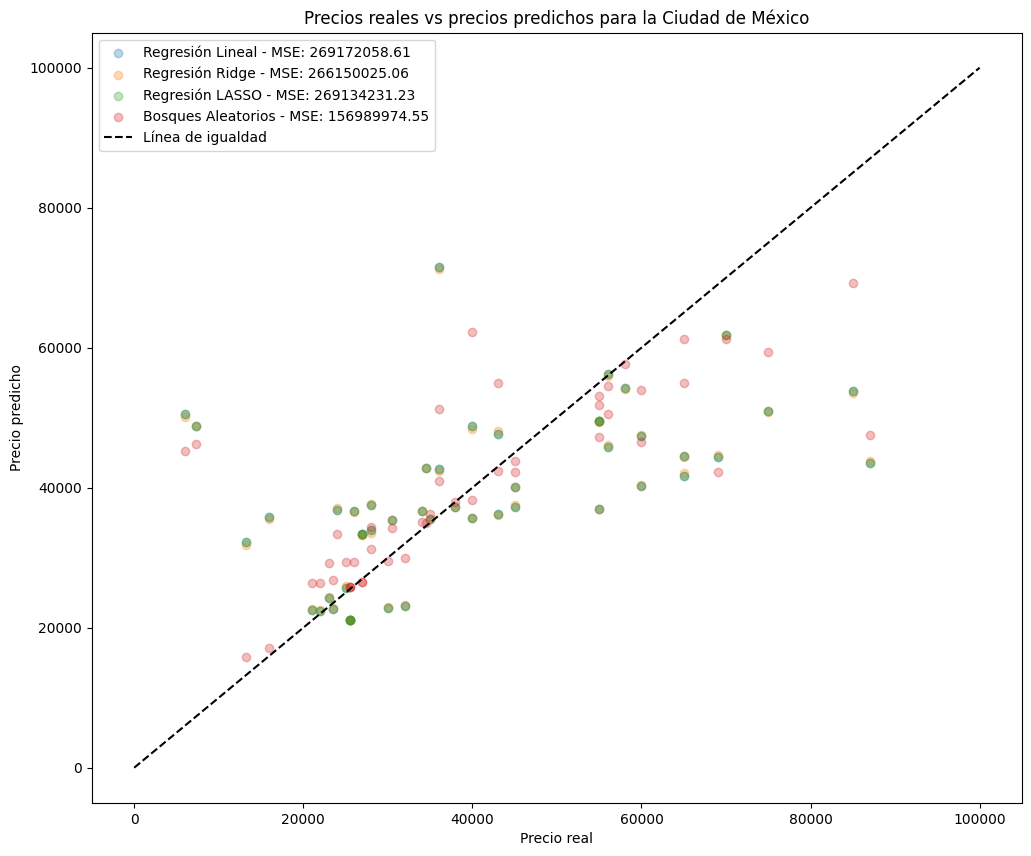

In [69]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np


X_encoded = df_modelo_miguel_hidalgo.drop(['precio'], axis=1)   
y_encoded = df_modelo_miguel_hidalgo['precio']

X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(X_encoded, y_encoded, test_size=0.3, random_state=42)

  
models = {
    'Regresión Lineal': LinearRegression(),
    'Regresión Ridge': Ridge(),
    'Regresión LASSO': Lasso(),
    'Bosques Aleatorios': RandomForestRegressor()
}

predictions_dict = {}

for model_name, model in models.items():
    model.fit(X_train_encoded, y_train_encoded)
    predictions_encoded = model.predict(X_test_encoded)
    predictions_dict[model_name] = predictions_encoded

plt.figure(figsize=(12, 10))

for model_name, predictions_encoded in predictions_dict.items():
    mse_encoded = mean_squared_error(y_test_encoded, predictions_encoded)
    plt.scatter(y_test_encoded, predictions_encoded, alpha=0.3, label=f'{model_name} - MSE: {mse_encoded:.2f}')

plt.plot(np.linspace(0, 100000, 1000), np.linspace(0, 100000, 1000), linestyle='--', color='black', label='Línea de igualdad')
plt.xlabel('Precio real')
plt.ylabel('Precio predicho')
plt.title('Precios reales vs precios predichos para la Ciudad de México')
plt.legend()
plt.show()

In [70]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

metrics_df = pd.DataFrame(index=models.keys(), columns=['MSE', 'MAE', 'R²'])

for model_name, predictions_encoded in predictions_dict.items():
    mse = mean_squared_error(y_test_encoded, predictions_encoded)
    mae = mean_absolute_error(y_test_encoded, predictions_encoded)
    r2 = r2_score(y_test_encoded, predictions_encoded)
    
    metrics_df.loc[model_name] = [mse, mae, r2]

print(metrics_df)


                                 MSE           MAE        R²
Regresión Lineal    269172058.610483  11628.506876  0.278382
Regresión Ridge      266150025.05841  11557.936011  0.286483
Regresión LASSO     269134231.226397   11627.61239  0.278483
Bosques Aleatorios  156989974.553081   7485.825625  0.579128


Conclusion:

Tras el realizamento de EDA pudimos encontrar importantes hallazgos en función de las caracteristicas más importantes que representan el valor de la propiedad, los diferentes anuncios expuestos en la plataforma de inmuebles 24 y la propuesta de solución para poder obtener una prediccion de precios dados las caracteristicas ingresadas.